# RL in Finance(Test Cash Penalty) 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sunnyswag/RL_in_Finance/blob/main/RL_in_Finance_Test_cash_penalty.ipynb)

## 1、拉取 github 仓库，下载并导入相关包
&emsp;&emsp;运行流程：python setup.py -> pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

%matplotlib inline
from utils import config
from utils.pull_data import Pull_data
from utils.preprocessors import FeatureEngineer, split_data
from utils.env_retreat_penalty import StockTradingEnvRetreatpenalty
from utils.models import DRL_Agent
from utils.backtest import backtest_stats, backtest_plot, get_baseline
import itertools
import sys
import codecs
sys.path.append("../RL_in_Finance")
# sys.stdout = codecs.getwriter("utf-8")(sys.stdout.detach())

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## 2、下载数据

数据来源：Tushare API<br>
当前用到的数据：SSE_50 和 CSI_300<br>
数据量的大小：shape[2892 * n, 8]

In [3]:
# stock_list = config.SSE_50
# df = Pull_data(stock_list, save_data=False).pull_data()

In [4]:
# df.sort_values(['date', 'tic'], ignore_index=True).head()

In [5]:
# print("数据下载的时间区间为：{} 至 {}".format(config.Start_Date, config.End_Date))

In [6]:
# print("下载的股票列表为: ")
# print(stock_list)

## 3、数据预处理

In [7]:
# processed_df = FeatureEngineer(use_technical_indicator=True).preprocess_data(df)
# processed_df['amount'] = processed_df.volume * processed_df.close
# processed_df['change'] = (processed_df.close-processed_df.open)/processed_df.close
# processed_df['daily_variance'] = (processed_df.high-processed_df.low)/processed_df.close

In [8]:
# processed_df = processed_df.fillna(0)

In [9]:
# print("技术指标列表: ")
# print(config.TECHNICAL_INDICATORS_LIST)
# print("技术指标数: {}个".format(len(config.TECHNICAL_INDICATORS_LIST)))

In [10]:
# processed_df.head()

In [11]:
# processed_df.to_csv("processed_df.csv", index = False)
processed_df = pd.read_csv("processed_df.csv")

In [12]:
train_data = split_data(processed_df, config.Start_Trade_Date, config.End_Trade_Date)
test_data = split_data(processed_df, config.End_Trade_Date, config.End_Test_Date)

In [13]:
print("训练数据的范围：{} 至 {}".format(config.Start_Trade_Date, config.End_Trade_Date))
print("测试数据的范围：{} 至 {}".format(config.End_Trade_Date, config.End_Test_Date))
print("训练数据的长度: {},测试数据的长度:{}".format(len(train_data), len(test_data)))
print("训练集数据 : 测试集数据: {} : {}".format(round(len(train_data)/len(test_data),1), 1))

训练数据的范围：2009-01-01 至 2019-01-01
测试数据的范围：2019-01-01 至 2021-01-01
训练数据的长度: 121550,测试数据的长度:24350
训练集数据 : 测试集数据: 5.0 : 1


In [14]:
train_data.head()

,date,tic,open,high,low,close,volume,day,boll_ub,boll_lb,...,macd,volume_20_sma,volume_60_sma,volume_120_sma,close_20_sma,close_60_sma,close_120_sma,amount,change,daily_variance
0,2009-01-05,600000.SH,2.7584,2.8115,2.7258,2.8013,503142.56,0.0,0.0,0.0,...,0.0,503142.56,503142.56,503142.56,2.8013,2.8013,2.8013,1.409453e+06,0.015314,0.030593
0,2009-01-05,600009.SH,9.4665,9.6505,9.4414,9.5836,52100.33,0.0,0.0,0.0,...,0.0,52100.33,52100.33,52100.33,9.5836,9.5836,9.5836,4.993087e+05,0.012219,0.021819
0,2009-01-05,600016.SH,1.6369,1.6487,1.6170,1.6448,947739.82,0.0,0.0,0.0,...,0.0,947739.82,947739.82,947739.82,1.6448,1.6448,1.6448,1.558842e+06,0.004803,0.019273
0,2009-01-05,600028.SH,3.1966,3.2461,3.1786,3.2371,361085.66,0.0,0.0,0.0,...,0.0,361085.66,361085.66,361085.66,3.2371,3.2371,3.2371,1.168870e+06,0.012511,0.020852
0,2009-01-05,600030.SH,9.2667,9.5705,9.1654,9.5502,818978.41,0.0,0.0,0.0,...,0.0,818978.41,818978.41,818978.41,9.5502,9.5502,9.5502,7.821408e+06,0.029685,0.042418


In [15]:
test_data.head()

,date,tic,open,high,low,close,volume,day,boll_ub,boll_lb,...,macd,volume_20_sma,volume_60_sma,volume_120_sma,close_20_sma,close_60_sma,close_120_sma,amount,change,daily_variance
0,2019-01-02,600000.SH,8.9589,9.0049,8.8117,8.9221,237628.22,2.0,10.502893,8.657577,...,-0.251945,2.152395e+05,2.430301e+05,2.210339e+05,9.580235,9.716063,9.475849,2.120143e+06,-0.004125,0.021654
0,2019-01-02,600009.SH,49.6941,49.8119,48.8298,49.4780,40051.97,2.0,51.140976,48.044854,...,0.025528,3.263298e+04,5.353243e+04,5.799566e+04,49.592915,49.906370,53.102410,1.981691e+06,-0.004368,0.019849
0,2019-01-02,600016.SH,5.0982,5.1071,5.0002,5.0358,579415.00,2.0,5.554261,4.922929,...,-0.108006,6.324888e+05,6.533327e+05,6.093035e+05,5.238595,5.419815,5.361655,2.917818e+06,-0.012391,0.021228
0,2019-01-02,600028.SH,4.4596,4.4684,4.3372,4.3809,2185583.70,2.0,5.502448,4.478342,...,-0.185334,1.141945e+06,1.169240e+06,1.067717e+06,4.990395,5.276185,5.487852,9.574824e+06,-0.017964,0.029948
0,2019-01-02,600030.SH,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


## 4、初始化环境

**state_space 由四部分组成 :** <br>
1. 当天的资金量
2. 每只股票当天的收盘价
3. 每只股票当天的持仓量
4. 股票数 * 技术指标数<br>
5. 当天成交量

**reward 的计算方式：**<br>
* reward 交易前的总资产-当天交易后的总资产 = 当天交易的手续费
* TODO：待改进

**action_space 的空间：**<br>
  * actions ∈[-100, 100]
  * 正数表示买入，负数表示卖出，0表示不进行买入卖出操作
  * 绝对值表示买入卖出的数量

In [16]:
# stock_dimension = len(df.tic.unique())
# state_space = 1 + 2*stock_dimension + \
#     len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension + stock_dimension
# print("stock_dimension: {}, state_space: {}".format(stock_dimension, state_space))

In [17]:
# 初始化环境的参数
information_cols = config.TECHNICAL_INDICATORS_LIST + ["close", "day", "amount", "change", "daily_variance"]

e_train_gym = StockTradingEnvRetreatpenalty(df = train_data,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='￥',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500,
                                patient=True,
                                random_start = True)

e_trade_gym = StockTradingEnvRetreatpenalty(df = test_data,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='￥',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500,
                                patient=True,
                                random_start = False)

caching data
data cached!
caching data
data cached!


In [18]:
# 对环境进行测试
# %debug
# observation = e_train_gym.reset() # 初始化环境，observation为环境状态
# count = 0
# total_reward = 0
# for t in range(300):
#     action = e_train_gym.action_space.sample() # 随机采样动作
#     observation, reward, done, info = e_train_gym.step(action) # 与环境交互，获得下一个state的值
#     total_reward += reward
#     if done:             
#         break
#     count+=1
#     # time.sleep(0.2)      #每次等待 0.2s
# print("count: ", count)
# print("reward: {}, done: {}".format(total_reward, done))

In [19]:
import multiprocessing

n_cores = multiprocessing.cpu_count() - 10
n_cores = 24
print("using {} cores".format(n_cores))

#this is our training env. It allows multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)

#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()

using 24 cores


## 5、开始训练

所用到的框架：stable_baseline3

In [20]:
agent = DRL_Agent(env = env_train)

In [22]:
# from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.0, 
             'learning_rate': 0.000005, 
             'batch_size': 256, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024 for _ in range(10)], 
#     "squash_output": True
}

model = agent.get_model("ppo",  
                        model_kwargs = ppo_params, 
                        policy_kwargs = policy_kwargs, verbose = 0)

# model = model.load("scaling_reward_24_cores.model", env = env_train)

{'n_steps': 256, 'ent_coef': 0.0, 'learning_rate': 5e-06, 'batch_size': 256, 'gamma': 0.99}


In [ ]:
model.learn(total_timesteps = 1000000, 
            eval_env = env_trade, 
            eval_freq = 500,
            log_interval = 1, 
            tb_log_name = 'env_cashpenalty_highlr',
            n_eval_episodes = 1)   

/opt/conda/lib/python3.6/site-packages/stable_baselines3/common/callbacks.py:327: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f38f5335160> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f38f53351d0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


In [ ]:
model.save("scaling_reward_{}_cores.model".format(n_cores))

## 6、测试

In [23]:
df_account_value, df_actions = DRL_Agent.DRL_prediction(
    model=model, 
    environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|RETREAT_PROPORTION


/home/RL_in_Finance/utils/env_retreat_penalty.py:257: RuntimeWarning: invalid value encountered in true_divide
  actions = actions / self.closings


   1|  51|CASH SHORTAGE  |￥35            |￥1,197,811     |17.94973% |19.78112% |-1.83%    
   1|  63|CASH SHORTAGE  |￥17,561        |￥1,210,178     |16.04825% |21.01782% |-4.97%    
   1|  72|CASH SHORTAGE  |￥31,509        |￥1,234,275     |20.35013% |23.42749% |-3.08%    
   1|  76|CASH SHORTAGE  |￥31,058        |￥1,211,115     |16.21553% |21.11152% |-4.90%    
   1|  78|CASH SHORTAGE  |￥53,794        |￥1,196,180     |13.54918% |19.61799% |-6.07%    
   1| 100|CASH SHORTAGE  |￥8,242         |￥1,099,090     |-3.78387% |9.90901%  |-13.69%   
   1| 103|CASH SHORTAGE  |￥37,486        |￥1,091,627     |-5.11623% |9.16270%  |-14.28%   
   1| 111|CASH SHORTAGE  |￥23,279        |￥1,181,094     |10.85599% |18.10942% |-7.25%    
   1| 117|CASH SHORTAGE  |￥19,667        |￥1,183,843     |11.34677% |18.38433% |-7.04%    
   1| 122|CASH SHORTAGE  |￥22,552        |￥1,204,154     |14.97273% |20.41538% |-5.44%    
   1| 131|CASH SHORTAGE  |￥25,469        |￥1,197,987     |13.87175% |19.79867% |-5.93%    

In [24]:
print("回测的时间窗口：{} 至 {}".format(config.End_Trade_Date, config.End_Test_Date))

回测的时间窗口：2019-01-01 至 2021-01-01


In [25]:
df_account_value.to_csv("df_account_value.csv", index=False)
print("查看日账户净值")
print("开始: ")
print(df_account_value.head())
print("")
print("结束: ")
print(df_account_value.tail())

查看日账户净值
开始: 
             cash    asset_value  total_assets    reward        date
0  1000000.000000       0.000000  1.000000e+06  0.000000  2019-01-03
1   930148.104242   69938.141489  1.000086e+06  0.000086  2019-01-04
2   900836.116516  102416.504153  1.003253e+06  0.003253  2019-01-07
3   852501.363810  151045.193709  1.003547e+06  0.003547  2019-01-08
4   846628.482218  156383.650940  1.003012e+06  0.002480  2019-01-09

结束: 
             cash   asset_value  total_assets    reward        date
481  48409.062325  1.779202e+06  1.827611e+06  0.766183  2020-12-25
482  22326.275614  1.810667e+06  1.832994e+06  0.774330  2020-12-28
483  34203.676168  1.791021e+06  1.825224e+06  0.762571  2020-12-29
484  85720.209921  1.745101e+06  1.830822e+06  0.771042  2020-12-30
485  94377.429300  1.761320e+06  1.855698e+06  0.808694  2020-12-31


In [26]:
print("查看每日所作的交易")
df_actions.to_csv("df_actions.csv", index=False)
df_actions.tail()

查看每日所作的交易


,date,actions,transactions
481,2020-12-25,"[0.44200552, -0.75738513, 1.0, 1.0, -0.0333368...","[231.41650134980364, -53.57088387678597, 972.7..."
482,2020-12-28,"[-0.88341963, -0.4989383, 0.53489697, 1.0, 0.5...","[-461.0749628947025, -34.248921008374516, 516...."
483,2020-12-29,"[0.58035547, -1.0, 0.70480704, 0.7643035, 0.09...","[0.0, -69.93006993006993, 0.0, 0.0, 0.0, 0.0, ..."
484,2020-12-30,"[0.025179317, -1.0, -1.0, 0.50126207, 0.120768...","[13.210554413130001, -68.54009595613434, -968...."
485,2020-12-31,"[-0.42952973, 0.73615146, 1.0, 1.0, -0.0519592...","[-226.06828227796052, 50.24238771797365, 967.1..."


## 7、回测

In [32]:
print("---------------------获取回测结果---------------------")
pref_stats_all = backtest_stats(account_value=df_account_value,
                               value_col_name = 'total_assets')

# perf_stats_all = pd.DataFrame(perf_stats_all)
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

---------------------获取回测结果---------------------
Annual return          0.378837
Cumulative returns     0.855698
Annual volatility      0.264843
Sharpe ratio           1.349130
Calmar ratio           1.718121
Stability              0.914950
Max drawdown          -0.220495
Omega ratio            1.279757
Sortino ratio          1.966408
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.220629
Daily value at risk   -0.031949
dtype: float64


In [28]:
# 获取 baseline 的结果
print("---------------------获取baseline结果---------------------")
baseline_df = get_baseline(config.SSE_50_INDEX, 
              start="20190101",
              end="20210101")
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

---------------------获取baseline结果---------------------
--- 开始下载 ----
--- 下载完成 ----
DataFrame 的大小:  (487, 8)
Annual return          0.271107
Cumulative returns     0.589776
Annual volatility      0.189096
Sharpe ratio           1.366667
Calmar ratio           1.487275
Stability              0.618053
Max drawdown          -0.182284
Omega ratio            1.286287
Sortino ratio          1.953108
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.078570
Daily value at risk   -0.022798
dtype: float64


In [29]:
# 删除 df_account_value 中重复的行
df_account_value.drop(df_account_value.index[1], inplace=True)

In [30]:
baseline_df.head(10)

,date,tic,open,high,low,close,volume,day
0,2019-01-02,000016.SH,2262.7908,2298.1805,2301.0552,2252.7479,20880697.0,2
1,2019-01-03,000016.SH,2269.2430,2259.4825,2287.7778,2253.9433,18895240.0,3
2,2019-01-04,000016.SH,2314.6466,2252.7449,2316.3528,2249.3658,25900596.0,4
3,2019-01-07,000016.SH,2314.3193,2329.0316,2331.6031,2306.8979,25278948.0,0
4,2019-01-08,000016.SH,2305.1708,2312.1705,2312.1705,2298.9548,18131160.0,1
5,2019-01-09,000016.SH,2332.7192,2320.9119,2360.3601,2318.4352,28747596.0,2
6,2019-01-10,000016.SH,2331.8507,2333.2162,2345.3313,2321.3049,22280507.0,3
7,2019-01-11,000016.SH,2354.4987,2342.0236,2360.0609,2334.9145,18417693.0,4
8,2019-01-14,000016.SH,2331.1358,2350.2560,2354.3082,2330.0042,16462252.0,0
9,2019-01-15,000016.SH,2378.3696,2337.7021,2380.5995,2332.4095,22466336.0,1


---------------------Plot---------------------
和 000016.SH 指数进行比较
--- 开始下载 ----
--- 下载完成 ----
DataFrame 的大小:  (487, 8)


Start date,2019-01-03
End date,2020-12-31
Total months,23
,Backtest
Annual return,37.884%
Cumulative returns,85.57%
Annual volatility,26.484%
Sharpe ratio,1.35
Calmar ratio,1.72
Stability,0.91
Max drawdown,-22.05%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.05,2020-02-26,2020-03-24,2020-07-06,94
1,16.02,2019-04-08,2019-05-07,2019-08-28,103
2,12.26,2020-07-10,2020-09-10,NaT,NaN
3,10.72,2020-01-23,2020-02-04,2020-02-19,20
4,6.37,2019-09-24,2019-10-21,2019-11-06,32


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


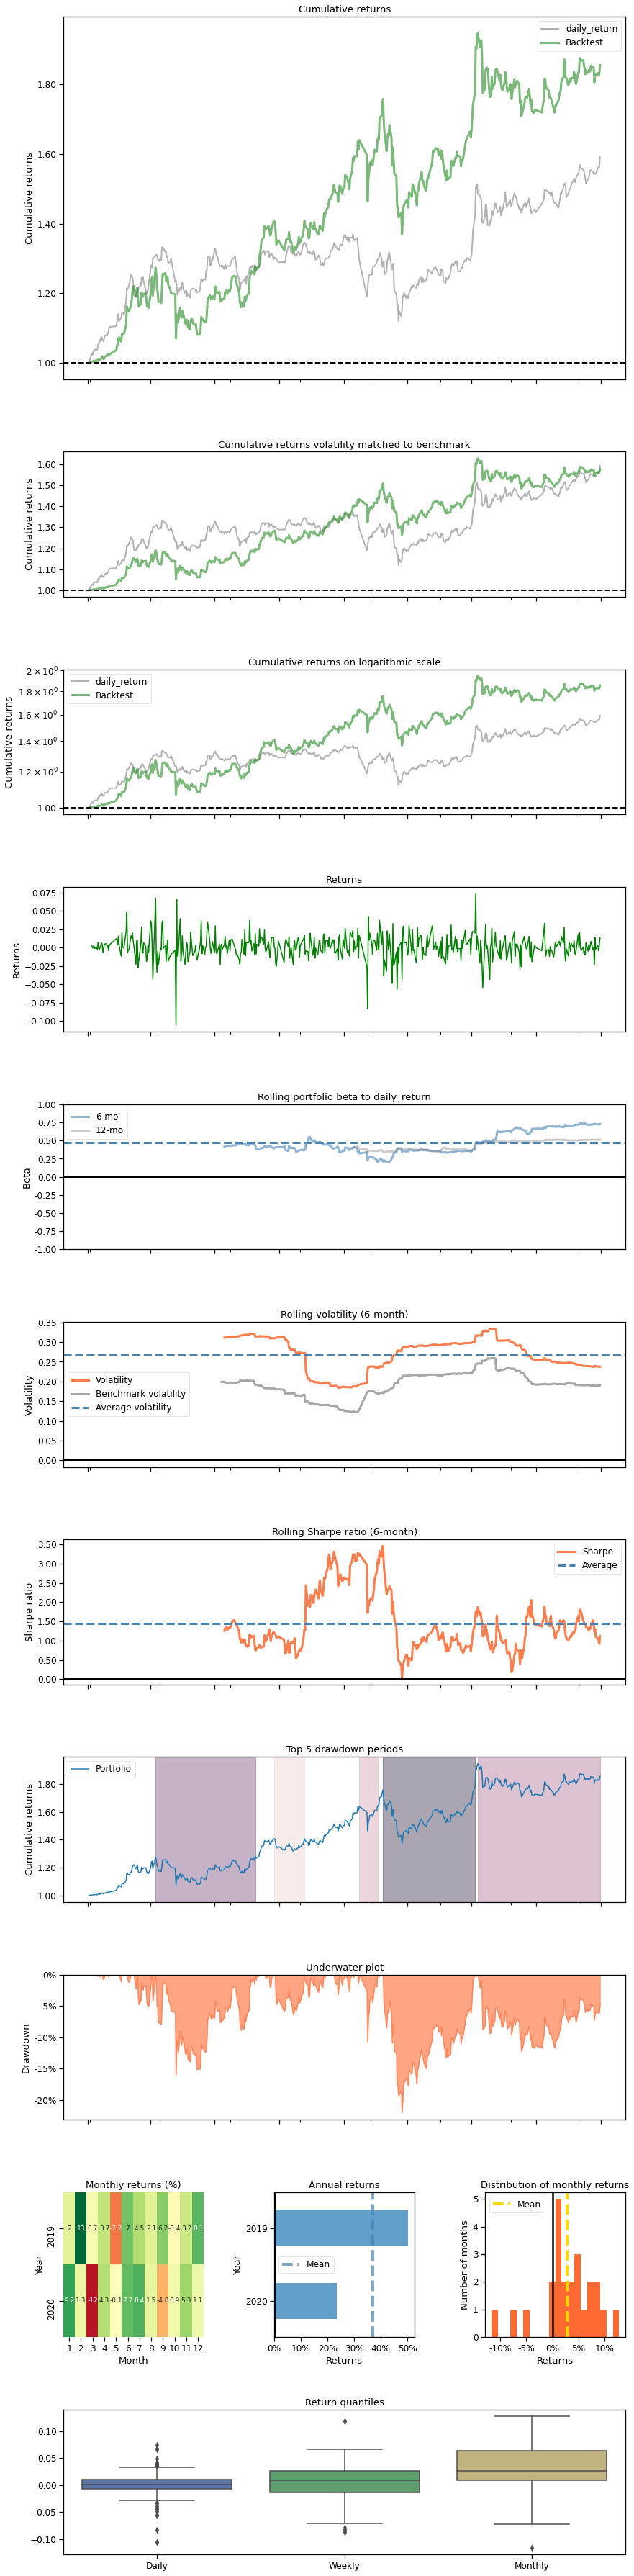

In [33]:
print("---------------------Plot---------------------")
print("和 {} 指数进行比较".format(config.SSE_50_INDEX[0]))
%matplotlib inline
backtest_plot(df_account_value,
        baseline_start="20190101",
        baseline_end="20210101",
        baseline_ticker=config.SSE_50_INDEX,
        value_col_name = 'total_assets'
      )